### Attempting to run regressions from systematics values extracted geometrically or from Kitanidis et al on galaxy density


In [96]:
import pandas as pd
import numpy as np
import pickle
import healpy as hp
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [97]:
### Setting Healpy Information
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg


### Importing Galaxy Density Information

In [98]:
df_objects = pd.read_csv('../bricks_data/galaxy_catalogue.csv')


In [99]:
df_objects = df_objects.drop_duplicates()

df_objects.head()

,BrickID,RA,DEC,Target_type,Fitbits,Maskbits
0,120312,5.165116,-39.411469,2,1,0
1,120312,5.165771,-39.443575,3,1,0
2,120312,5.167412,-39.552630,2,1,0
3,120312,5.169102,-39.400914,3,1,0
4,120312,5.169548,-39.533226,3,1,0


In [100]:
# LRG

df_LRG = df_objects[df_objects["Target_type"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block
density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, density_LRG), axis=1)
print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg_density'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 4271038
[  1564   1574   1577 ... 757955 758427 758428]
Mean LRGs per Pixel: 14.987518115751318
[[ 1.56400000e+03 -8.66555624e-01]
 [ 1.57400000e+03 -7.33111248e-01]
 [ 1.57700000e+03 -9.33277812e-01]
 ...
 [ 7.57955000e+05 -7.99833436e-01]
 [ 7.58427000e+05 -9.33277812e-01]
 [ 7.58428000e+05 -7.99833436e-01]]


,pixel_id,lrg_density
0,1564,-0.866556
1,1574,-0.733111
2,1577,-0.933278
3,1668,-0.799833
4,1669,-0.866556


In [101]:
# elg

df_ELG = df_objects[df_objects["Target_type"] == 2]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, density_ELG), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg_density'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 14963034
[  1564   1574   1577 ... 758427 758428 758430]
Mean ELGs per Pixel: 49.39322037255271
[[ 1.56400000e+03 -9.19017226e-01]
 [ 1.57400000e+03 -9.59508613e-01]
 [ 1.57700000e+03 -8.58280146e-01]
 ...
 [ 7.58427000e+05 -8.78525839e-01]
 [ 7.58428000e+05 -7.77297372e-01]
 [ 7.58430000e+05 -8.78525839e-01]]
   pixel_id  elg_density
0      1564    -0.919017
1      1574    -0.959509
2      1577    -0.858280
3      1668    -0.736806
4      1669    -0.676069


In [102]:
df_QSO = df_objects[df_objects["Target_type"] == 3]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, density_QSO), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso_density'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 20596063
[  1562   1563   1564 ... 758427 758428 758430]
Mean QSOs per Pixel: 67.3102550108338
[[ 1.56200000e+03 -9.70286846e-01]
 [ 1.56300000e+03 -9.40573691e-01]
 [ 1.56400000e+03 -8.81147382e-01]
 ...
 [ 7.58427000e+05 -8.81147382e-01]
 [ 7.58428000e+05 -9.10860537e-01]
 [ 7.58430000e+05 -9.40573691e-01]]
   pixel_id  qso_density
0      1562    -0.970287
1      1563    -0.940574
2      1564    -0.881147
3      1574    -0.910861
4      1577    -0.896004


In [103]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id           0
lrg_density    24826
elg_density     6862
qso_density     3812
dtype: int64
(284973, 2) (302937, 2) (305987, 2) (309799, 4)


In [104]:
# Dropping all pixels where I do not have densities for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())

pixel_id       0
lrg_density    0
elg_density    0
qso_density    0
dtype: int64


In [105]:
print( df.shape)


(282196, 4)


### Importing the Systematics Values and Appending them to the df.


#### Stellar Density

In [106]:
df_stellar = pd.read_csv('../bricks_data/stellar_catalogue.csv')
df_stellar.shape


(4524152, 5)

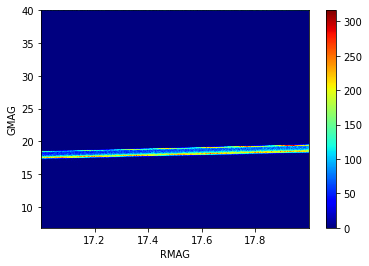

In [107]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [108]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(4524152, 5)


In [109]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [110]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4) ]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4) ]
print(df_stellar.shape)


(4357535, 7)


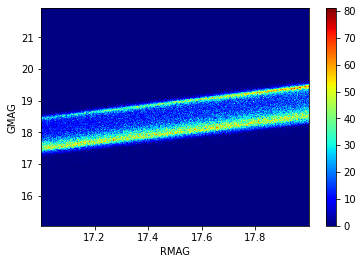

In [111]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [112]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=1000, labels=False)
df_stellar['percent_RMAG'].value_counts()


573    4373
316    4373
759    4373
394    4372
507    4372
       ... 
754    4342
760    4342
368    4342
351    4342
653    4341
Name: percent_RMAG, Length: 1000, dtype: int64

In [113]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [114]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=1000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=1000, labels=False)
df_stellar.shape

(4357535, 12)

In [115]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [116]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [117]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(4357535, 12)
(4325356, 12)


(4306587, 12)

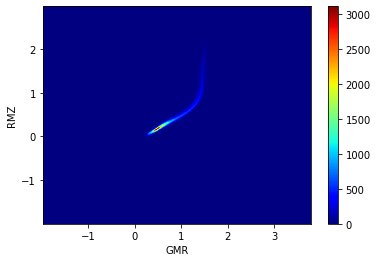

In [118]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [119]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, density_stellar), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar_density'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 4306587
[  1562   1574   1577 ... 757954 757955 758427]
Mean stellars per Pixel: 15.356262368735402
[[ 1.56200000e+03 -9.34879987e-01]
 [ 1.57400000e+03 -8.04639962e-01]
 [ 1.57700000e+03 -9.34879987e-01]
 ...
 [ 7.57954000e+05 -5.44159911e-01]
 [ 7.57955000e+05 -7.39519949e-01]
 [ 7.58427000e+05 -8.69759975e-01]]
   pixel_id  stellar_density
0      1562         -0.93488
1      1574         -0.80464
2      1577         -0.93488
3      1673         -0.73952
4      1675         -0.15344
pixel_id           0
stellar_density    0
dtype: int64


In [120]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id           0
lrg_density        0
elg_density        0
qso_density        0
stellar_density    0
dtype: int64


(268108, 5)

#### Kitanidis Systematics Values

In [12]:
with open('../bricks_data/pixel2systematics_kitanidis.pickle', 'rb') as f:
    kitanidis_dict = pickle.load(f)
    f.close()

print(len(kitanidis_dict.keys()))

1567


In [13]:
pixel_keys = kitanidis_dict.keys()

sys_list = []
for key in pixel_keys:
    ind_sys_list = kitanidis_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_kit = pd.DataFrame(sys_list, columns=['airmass_galaxy',
'fwhm_galaxy',
'ebv_galaxy',
'ccdnphotom_galaxy',

'ccdskysb_galaxy_g',
'ccdskysb_galaxy_r',
'ccdskysb_galaxy_z',
'exptime_galaxy_g',
'exptime_galaxy_r',
'exptime_galaxy_z',
'meansky_galaxy_g',
'meansky_galaxy_r',
'meansky_galaxy_z',
'galdepth_galaxy_g',
'galdepth_galaxy_r',
'galdepth_galaxy_z', 'pixel_id'])



In [14]:
df_sys_kit.head()

,airmass_galaxy,fwhm_galaxy,ebv_galaxy,ccdnphotom_galaxy,ccdskysb_galaxy_g,ccdskysb_galaxy_r,ccdskysb_galaxy_z,exptime_galaxy_g,exptime_galaxy_r,exptime_galaxy_z,meansky_galaxy_g,meansky_galaxy_r,meansky_galaxy_z,galdepth_galaxy_g,galdepth_galaxy_r,galdepth_galaxy_z,pixel_id
0,1.204206,4.569465,0.021082,273.100211,23.627050,22.730956,20.206251,90.0,90.0,90.0,2.390975e+08,6.489436e+08,2.384546e+09,23.111424,23.139025,22.097923,741107
1,1.069105,4.824085,0.010359,148.191320,23.601375,22.732608,20.000021,90.0,90.0,90.0,1.803126e+08,2.993781e+08,2.225294e+10,23.353823,23.320494,21.550398,662895
2,1.108757,4.413348,0.011393,154.348513,23.602864,22.701580,20.073285,90.0,90.0,90.0,2.952632e+08,8.687714e+08,1.152634e+10,23.062541,22.892199,21.675296,662913
3,1.104669,4.394738,0.011230,153.649709,23.613133,22.710532,20.111641,90.0,90.0,90.0,2.446651e+08,9.609978e+08,8.914973e+09,23.186001,22.788259,21.786543,663905
4,1.107077,4.439277,0.014093,150.531232,23.583476,22.647124,20.197871,90.0,90.0,90.0,3.645015e+08,6.979010e+08,9.072512e+09,22.836915,23.042679,21.724951,652792


In [15]:
df_kitanidis = df.merge(df_sys_kit, how='inner', on='pixel_id')
print(df_kitanidis.isna().sum())
df_kitanidis.dropna(axis=0, inplace=True)

df_kitanidis.head()


pixel_id             0
lrg_density          0
elg_density          0
qso_density          0
stellar_density      0
airmass_galaxy       0
fwhm_galaxy          0
ebv_galaxy           0
ccdnphotom_galaxy    0
ccdskysb_galaxy_g    3
ccdskysb_galaxy_r    0
ccdskysb_galaxy_z    0
exptime_galaxy_g     0
exptime_galaxy_r     0
exptime_galaxy_z     0
meansky_galaxy_g     0
meansky_galaxy_r     0
meansky_galaxy_z     0
galdepth_galaxy_g    0
galdepth_galaxy_r    0
galdepth_galaxy_z    0
dtype: int64


,pixel_id,lrg_density,elg_density,qso_density,stellar_density,airmass_galaxy,fwhm_galaxy,ebv_galaxy,ccdnphotom_galaxy,ccdskysb_galaxy_g,...,ccdskysb_galaxy_z,exptime_galaxy_g,exptime_galaxy_r,exptime_galaxy_z,meansky_galaxy_g,meansky_galaxy_r,meansky_galaxy_z,galdepth_galaxy_g,galdepth_galaxy_r,galdepth_galaxy_z
0,172191,0.509522,1.180820,0.787620,-0.279689,1.615369,4.563708,0.027940,617.485215,23.461968,...,19.328887,143.100496,139.892237,122.275265,0.199914,0.920791,2.869334,23.626332,22.942529,22.215109
1,173250,1.817774,2.133008,1.410579,1.263834,1.551244,4.652137,0.022238,997.009628,23.454327,...,19.084433,158.096504,82.525712,165.945433,0.203127,0.499488,3.490955,23.604491,22.966942,22.331463
2,174071,0.106983,0.750799,0.191747,-0.794197,1.406610,4.458577,0.018477,367.511248,23.441590,...,19.497361,128.317445,87.744524,106.219834,0.213351,0.564238,1.995409,23.598964,22.922293,22.342016
3,174554,0.106983,0.658651,0.083406,0.955130,2.301381,6.055535,0.131243,459.871429,23.432264,...,19.849928,200.000000,124.000000,221.028571,0.126744,0.333307,3.754301,24.007800,23.363166,22.229356
4,175096,1.515870,3.146629,1.329324,-0.485492,1.440663,4.587659,0.018841,373.382383,23.452281,...,19.589021,128.873803,83.743415,107.265548,0.293171,0.540003,6.617020,23.605227,22.900591,22.310904


In [16]:
print(df_kitanidis.isna().sum())

pixel_id             0
lrg_density          0
elg_density          0
qso_density          0
stellar_density      0
airmass_galaxy       0
fwhm_galaxy          0
ebv_galaxy           0
ccdnphotom_galaxy    0
ccdskysb_galaxy_g    0
ccdskysb_galaxy_r    0
ccdskysb_galaxy_z    0
exptime_galaxy_g     0
exptime_galaxy_r     0
exptime_galaxy_z     0
meansky_galaxy_g     0
meansky_galaxy_r     0
meansky_galaxy_z     0
galdepth_galaxy_g    0
galdepth_galaxy_r    0
galdepth_galaxy_z    0
dtype: int64


#### Geometric Systematics Values

In [69]:
with open('../bricks_data/pixel2systematics_geometric.pickle', 'rb') as f:
    geometric_dict = pickle.load(f)
    f.close()

print(len(geometric_dict.keys()))


455672


In [72]:
# Clear the dict of all pixels where we do not have galaxy density values

pixels = df.pixel_id.tolist()
pixel_keys = list(geometric_dict.keys())
for pix in pixels:
    if pix in geometric_dict:
        continue
    geometric_dict.pop(pix)
print(len(geometric_dict.keys()))


449346


In [73]:
sys_list = []
for key in geometric_dict.keys():
    ind_sys_list = geometric_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo = pd.DataFrame(sys_list, columns=['airmass_galaxy',
'fwhm_galaxy',
'ebv_galaxy',
'ccdnphotom_galaxy',

'ccdskysb_galaxy_g',
'ccdskysb_galaxy_r',
'ccdskysb_galaxy_z',
'exptime_galaxy_g',
'exptime_galaxy_r',
'exptime_galaxy_z',
'meansky_galaxy_g',
'meansky_galaxy_r',
'meansky_galaxy_z',
'galdepth_galaxy_g',
'galdepth_galaxy_r',
'galdepth_galaxy_z', 'pixel_id'])



In [74]:
df_sys_geo.head()

,airmass_galaxy,fwhm_galaxy,ebv_galaxy,ccdnphotom_galaxy,ccdskysb_galaxy_g,ccdskysb_galaxy_r,ccdskysb_galaxy_z,exptime_galaxy_g,exptime_galaxy_r,exptime_galaxy_z,meansky_galaxy_g,meansky_galaxy_r,meansky_galaxy_z,galdepth_galaxy_g,galdepth_galaxy_r,galdepth_galaxy_z,pixel_id
0,1.195260,4.480255,0.008298,123.020284,0.354085,0.345804,0.316945,2.581439,2.247159,3.030441,1.037392e+07,2.092525e+07,4.846495e+07,0.362631,0.359745,0.348780,655892
1,1.249056,5.037025,0.007363,122.206338,0.353643,0.345590,0.316987,2.634139,2.273438,3.057155,1.084173e+07,2.155979e+07,4.931969e+07,0.361698,0.359152,0.348086,656913
2,1.219710,4.655981,0.010609,127.602380,0.353842,0.345630,0.316968,2.636238,2.279095,3.058553,1.047120e+07,2.328702e+07,4.832188e+07,0.363175,0.360344,0.349086,655894
3,1.224886,4.782704,0.015070,132.282066,0.353030,0.345209,0.316962,2.677951,2.304308,3.084762,1.122897e+07,2.211558e+07,5.383919e+07,0.361758,0.359045,0.347981,655895
4,1.198163,4.526175,0.013152,132.935945,0.353712,0.345512,0.316819,2.639509,2.272059,3.052377,1.013292e+07,2.024901e+07,5.878297e+07,0.363083,0.359963,0.347816,655896


In [77]:
df_geometric = df.merge(df_sys_geo, how='inner', on='pixel_id')
print(df_geometric.isna().sum())
df_geometric.dropna(axis=0, inplace=True)
print(df_geometric.isna().sum())

pixel_id              0
lrg_density           0
elg_density           0
qso_density           0
stellar_density       0
airmass_galaxy        0
fwhm_galaxy           0
ebv_galaxy            0
ccdnphotom_galaxy     0
ccdskysb_galaxy_g    29
ccdskysb_galaxy_r    31
ccdskysb_galaxy_z     4
exptime_galaxy_g      0
exptime_galaxy_r      0
exptime_galaxy_z      0
meansky_galaxy_g      0
meansky_galaxy_r      0
meansky_galaxy_z      0
galdepth_galaxy_g     0
galdepth_galaxy_r     0
galdepth_galaxy_z     0
dtype: int64
pixel_id             0
lrg_density          0
elg_density          0
qso_density          0
stellar_density      0
airmass_galaxy       0
fwhm_galaxy          0
ebv_galaxy           0
ccdnphotom_galaxy    0
ccdskysb_galaxy_g    0
ccdskysb_galaxy_r    0
ccdskysb_galaxy_z    0
exptime_galaxy_g     0
exptime_galaxy_r     0
exptime_galaxy_z     0
meansky_galaxy_g     0
meansky_galaxy_r     0
meansky_galaxy_z     0
galdepth_galaxy_g    0
galdepth_galaxy_r    0
galdepth_galaxy_z    0


#### Geometric Systematics Values, not involving edge pixels

In [121]:
with open('../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geometric_dict_no = pickle.load(f)
    f.close()

print(len(geometric_dict_no.keys()))

455672


In [122]:
pixels = df.pixel_id.tolist()
pixel_keys = list(geometric_dict_no.keys())
for pix in pixels:
    if pix in geometric_dict_no:
        continue
    geometric_dict_no.pop(pix)
print(len(geometric_dict_no.keys()))


455672


In [123]:
sys_list = []
for key in geometric_dict_no.keys():
    ind_sys_list = geometric_dict_no[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass_galaxy',
'fwhm_galaxy',
'ebv_galaxy',
'ccdnphotom_galaxy',

'ccdskysb_galaxy_g',
'ccdskysb_galaxy_r',
'ccdskysb_galaxy_z',
'exptime_galaxy_g',
'exptime_galaxy_r',
'exptime_galaxy_z',
'meansky_galaxy_g',
'meansky_galaxy_r',
'meansky_galaxy_z',
'galdepth_galaxy_g',
'galdepth_galaxy_r',
'galdepth_galaxy_z', 'pixel_id'])



In [124]:
df_geometric_no = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(df_geometric_no.isna().sum())
df_geometric_no.dropna(axis=0, inplace=True)
print(df_geometric_no.isna().sum())

pixel_id              0
lrg_density           0
elg_density           0
qso_density           0
stellar_density       0
airmass_galaxy        0
fwhm_galaxy           0
ebv_galaxy            0
ccdnphotom_galaxy     0
ccdskysb_galaxy_g    38
ccdskysb_galaxy_r    29
ccdskysb_galaxy_z     2
exptime_galaxy_g      0
exptime_galaxy_r      0
exptime_galaxy_z      0
meansky_galaxy_g      0
meansky_galaxy_r      0
meansky_galaxy_z      0
galdepth_galaxy_g     0
galdepth_galaxy_r     0
galdepth_galaxy_z     0
dtype: int64
pixel_id             0
lrg_density          0
elg_density          0
qso_density          0
stellar_density      0
airmass_galaxy       0
fwhm_galaxy          0
ebv_galaxy           0
ccdnphotom_galaxy    0
ccdskysb_galaxy_g    0
ccdskysb_galaxy_r    0
ccdskysb_galaxy_z    0
exptime_galaxy_g     0
exptime_galaxy_r     0
exptime_galaxy_z     0
meansky_galaxy_g     0
meansky_galaxy_r     0
meansky_galaxy_z     0
galdepth_galaxy_g    0
galdepth_galaxy_r    0
galdepth_galaxy_z    0


In [126]:
df_geometric_no.to_csv('../bricks_data/dataset_geometric.csv')

In [83]:
print(df_geometric.describe())
print(df_geometric_no.describe())

            pixel_id    lrg_density    elg_density    qso_density  \
count  209251.000000  209251.000000  209251.000000  209251.000000   
mean   418790.556322       0.051484       0.111896       0.123380   
std    167398.328564       0.815933       0.741487       0.733189   
min    163024.000000      -0.933864      -0.980077      -0.985781   
25%    280429.500000      -0.603185      -0.521843      -0.516557   
50%    387938.000000      -0.074099       0.036006       0.052200   
75%    550847.500000       0.521123       0.673548       0.692051   
max    758427.000000      33.985821      35.658665      17.001146   

       stellar_density  airmass_galaxy    fwhm_galaxy     ebv_galaxy  \
count    209251.000000   209251.000000  209251.000000  209251.000000   
mean          0.036881        1.408712       4.569643       0.044514   
std           1.208060        0.259969       0.747281       0.032532   
min          -0.934850        0.048958       0.123203       0.001088   
25%          -0.67

In [85]:
#print(df_kitanidis.shape)
print(df_geometric.shape)
print(df_geometric_no.shape)


(209251, 21)
(209307, 21)


### Running the Regressions

#### 1. Kitanidis

In [23]:
df_kitanidis.head()
df_kitanidis_reg = df_kitanidis.drop(columns=['pixel_id'])
df_kitanidis_reg.head()

,lrg_density,elg_density,qso_density,stellar_density,airmass_galaxy,fwhm_galaxy,ebv_galaxy,ccdnphotom_galaxy,ccdskysb_galaxy_g,ccdskysb_galaxy_r,ccdskysb_galaxy_z,exptime_galaxy_g,exptime_galaxy_r,exptime_galaxy_z,meansky_galaxy_g,meansky_galaxy_r,meansky_galaxy_z,galdepth_galaxy_g,galdepth_galaxy_r,galdepth_galaxy_z
0,0.509522,1.180820,0.787620,-0.279689,1.615369,4.563708,0.027940,617.485215,23.461968,22.460363,19.328887,143.100496,139.892237,122.275265,0.199914,0.920791,2.869334,23.626332,22.942529,22.215109
1,1.817774,2.133008,1.410579,1.263834,1.551244,4.652137,0.022238,997.009628,23.454327,22.586219,19.084433,158.096504,82.525712,165.945433,0.203127,0.499488,3.490955,23.604491,22.966942,22.331463
2,0.106983,0.750799,0.191747,-0.794197,1.406610,4.458577,0.018477,367.511248,23.441590,22.625744,19.497361,128.317445,87.744524,106.219834,0.213351,0.564238,1.995409,23.598964,22.922293,22.342016
3,0.106983,0.658651,0.083406,0.955130,2.301381,6.055535,0.131243,459.871429,23.432264,22.486569,19.849928,200.000000,124.000000,221.028571,0.126744,0.333307,3.754301,24.007800,23.363166,22.229356
4,1.515870,3.146629,1.329324,-0.485492,1.440663,4.587659,0.018841,373.382383,23.452281,22.653194,19.589021,128.873803,83.743415,107.265548,0.293171,0.540003,6.617020,23.605227,22.900591,22.310904


In [24]:
y_lrg = df_kitanidis_reg['lrg_density']#.to_numpy(copy=True)
y_elg = df_kitanidis_reg['elg_density']#.to_numpy(copy=True)
y_qso = df_kitanidis_reg['qso_density']#.to_numpy(copy=True)

X = df_kitanidis_reg.drop(columns=['lrg_density','elg_density','qso_density'])#.to_numpy(copy=True)

In [25]:
print(len(y_lrg))
print(len(X))

1535
1535


In [26]:


ols_lrg_kitanidis = sm.OLS(y_lrg,X).fit()
print(ols_lrg_kitanidis.summary())



                                 OLS Regression Results                                
Dep. Variable:            lrg_density   R-squared (uncentered):                   0.477
Model:                            OLS   Adj. R-squared (uncentered):              0.471
Method:                 Least Squares   F-statistic:                              81.43
Date:                Wed, 16 Jun 2021   Prob (F-statistic):                   2.67e-199
Time:                        18:08:54   Log-Likelihood:                         -2213.4
No. Observations:                1535   AIC:                                      4461.
Df Residuals:                    1518   BIC:                                      4551.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [27]:
ols_elg_kitanidis = sm.OLS(y_elg,X).fit()
print(ols_elg_kitanidis.summary())

                                 OLS Regression Results                                
Dep. Variable:            elg_density   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              284.5
Date:                Wed, 16 Jun 2021   Prob (F-statistic):                        0.00
Time:                        18:09:26   Log-Likelihood:                         -1594.0
No. Observations:                1535   AIC:                                      3222.
Df Residuals:                    1518   BIC:                                      3313.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [28]:
ols_qso_kitanidis = sm.OLS(y_qso,X).fit()
print(ols_qso_kitanidis.summary())

                                 OLS Regression Results                                
Dep. Variable:            qso_density   R-squared (uncentered):                   0.781
Model:                            OLS   Adj. R-squared (uncentered):              0.779
Method:                 Least Squares   F-statistic:                              318.6
Date:                Wed, 16 Jun 2021   Prob (F-statistic):                        0.00
Time:                        18:09:37   Log-Likelihood:                         -1534.7
No. Observations:                1535   AIC:                                      3103.
Df Residuals:                    1518   BIC:                                      3194.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

#### 2. Geometric

In [86]:
df_geometric.head()
df_geometric_reg = df_geometric.drop(columns=['pixel_id'])
df_geometric_reg.head()

,lrg_density,elg_density,qso_density,stellar_density,airmass_galaxy,fwhm_galaxy,ebv_galaxy,ccdnphotom_galaxy,ccdskysb_galaxy_g,ccdskysb_galaxy_r,ccdskysb_galaxy_z,exptime_galaxy_g,exptime_galaxy_r,exptime_galaxy_z,meansky_galaxy_g,meansky_galaxy_r,meansky_galaxy_z,galdepth_galaxy_g,galdepth_galaxy_r,galdepth_galaxy_z
0,-0.933864,-0.701152,-0.800935,-0.934850,1.157527,3.952116,0.015481,1531.291708,0.364868,0.350619,0.308676,1.565104,1.294643,1.583741,0.003405,0.010923,0.027437,0.365975,0.356016,0.350135
1,-0.537050,-0.402304,-0.715622,-0.087907,1.395075,4.260359,0.015946,1297.446720,0.364789,0.352108,0.306131,1.745117,1.327699,1.339617,0.003545,0.010409,0.032368,0.366929,0.356678,0.350109
2,0.124308,0.334854,-0.118427,1.019635,1.382828,4.219695,0.017363,1423.569447,0.364740,0.350370,0.308560,1.585069,1.335547,1.744228,0.003428,0.011522,0.033258,0.366355,0.356583,0.348375
3,-0.603185,-0.661306,-0.701403,-0.804551,1.174756,3.827847,0.016397,1652.704145,0.364805,0.352598,0.307511,1.531250,1.230937,1.304422,0.003692,0.010843,0.025915,0.366107,0.355722,0.349798
4,-0.669321,-0.840614,-0.914687,-0.739402,1.156410,4.113628,0.018817,1470.870035,0.365766,0.350320,0.303798,2.165625,1.440625,1.333238,0.003620,0.012163,0.032397,0.365827,0.357129,0.348684


In [87]:
y_lrg = df_geometric_reg['lrg_density']#.to_numpy(copy=True)
y_elg = df_geometric_reg['elg_density']#.to_numpy(copy=True)
y_qso = df_geometric_reg['qso_density']#.to_numpy(copy=True)

X = df_geometric_reg.drop(columns=['lrg_density','elg_density','qso_density'])#.to_numpy(copy=True)

In [88]:
print(len(y_lrg))
print(len(X))

209251
209251


In [89]:
ols_lrg_geometric = sm.OLS(y_lrg,X).fit()
print(ols_lrg_geometric.summary())
print()
ols_elg_geometric = sm.OLS(y_elg,X).fit()
print(ols_elg_geometric.summary())
print()
ols_qso_geometric = sm.OLS(y_qso,X).fit()
print(ols_qso_geometric.summary())


                            OLS Regression Results                            
Dep. Variable:            lrg_density   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     5652.
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:06:53   Log-Likelihood:            -2.1676e+05
No. Observations:              209251   AIC:                         4.336e+05
Df Residuals:                  209234   BIC:                         4.337e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
stellar_density       0.4663      0.00

### 3. Geometric, non-inclusive of edge CCDs

In [93]:
df_geometric_no_reg = df_geometric_no.drop(columns=['pixel_id'])


y_lrg = df_geometric_no_reg['lrg_density']#.to_numpy(copy=True)
y_elg = df_geometric_no_reg['elg_density']#.to_numpy(copy=True)
y_qso = df_geometric_no_reg['qso_density']#.to_numpy(copy=True)

X = df_geometric_no_reg.drop(columns=['lrg_density','elg_density','qso_density'])#.to_numpy(copy=True)

In [94]:
ols_lrg_geometric_no = sm.OLS(y_lrg,X).fit()
print(ols_lrg_geometric_no.summary())
ols_elg_geometric_no = sm.OLS(y_elg,X).fit()
print(ols_elg_geometric_no.summary())
ols_qso_geometric_no = sm.OLS(y_qso,X).fit()
print(ols_qso_geometric_no.summary())


                                 OLS Regression Results                                
Dep. Variable:            lrg_density   R-squared (uncentered):                   0.299
Model:                            OLS   Adj. R-squared (uncentered):              0.299
Method:                 Least Squares   F-statistic:                              5254.
Date:                Thu, 24 Jun 2021   Prob (F-statistic):                        0.00
Time:                        16:09:08   Log-Likelihood:                     -2.1758e+05
No. Observations:              209266   AIC:                                  4.352e+05
Df Residuals:                  209249   BIC:                                  4.354e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------